## Importing the libraries

In [1]:
import pandas as pd
import re
import math
import requests
import json

## Importing the Dataset

In [2]:
df = pd.read_csv('phishing_site_urls.csv')
df.head()

URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad

## Global Variables

In [3]:
# @Globals
bad_urls = 0
bad_url_tldSet = set()
bad_url_tld_frequency = {}
bad_url_word_frequency = {}

good_urls = 0
good_url_tldSet = set()
good_url_tld_frequency = {}
good_url_word_frequency = {}

## Helper Functions

In [4]:
def count_digits(word):
  return len(re.findall('[0-9]', word))

def count_alphabets(word):
  return len(re.findall('[A-z]', word))

def count_special_characters(input_string):
  special_characters = "!@#$%^&*()-_=+[]{}|;:',.<>/?"
  count = 0

  for char in input_string:
    if char not in special_characters and not char.isalnum():
      count += 1

  return count

def remove_special_characters(input_string):
  # Pattern to match any non-alphanumeric and non-space character
  pattern = r'[^a-zA-Z0-9\s]'  
  return re.sub(pattern, '', input_string)

def calculate_entropy(word):
  if len(word) == 0:
    return 0

  entropy = 0
  word_length = len(word)
  char_count = {}

  for char in word:
    if char in char_count:
      char_count[char] += 1
    else:
      char_count[char] = 1

  for char in char_count:
    probability = char_count[char] / word_length
    entropy += -probability * math.log2(probability)

  return entropy

# https://www.whoisxmlapi.com/whoisserver/WhoisService?apiKey=at_BGLU4RpM0fcKHpqsqHAYRWFl4bIt2&domainName=facebook.com
# Rapid API Key: d2592fe48dmsh190428470dadf9cp1bf762jsnf40816e6115e (Shauryansingh23102001@gmail.com)

# FUNCTION TO MAKE REQUEST TO WHOISAPI THROUGH RAPIDAPI (Not in use currently)
def whois_api_request(api_key, domain_url):
    url = "https://whoisapi-whois-v2-v1.p.rapidapi.com/whoisserver/WhoisService"

    headers = {
	    "X-RapidAPI-Key": "d2592fe48dmsh190428470dadf9cp1bf762jsnf40816e6115e",
	    "X-RapidAPI-Host": "whoisapi-whois-v2-v1.p.rapidapi.com"
    }

    querystring = {
        "domainName":domain_url,
        "apiKey":api_key,
        "outputFormat":"JSON",
        "da":"0",
        "ipwhois":"1",
        "thinWhois":"0",
        "_parse":"0",
        "preferfresh":"1",
        "checkproxydata":"0",
        "ip":"1"
    }
    
    response = requests.get(url, headers=headers, params=querystring)
    
    return response

# FUNCTION TO MAKE REQUEST TO WHOISAPI DIRECTLY (Not in use currently)
def get_whois_data(api_key, domain_name):
  base_url = "https://www.whoisxmlapi.com/whoisserver/WhoisService"
  params = {
    "apiKey": api_key,
    "domainName": domain_name,
    "outputFormat":"JSON",
    "preferfresh":"1",
  }

  response = requests.get(base_url, params=params)
  return response

## Selecting Dataframe Rows for Whois API Call

In [ ]:
#LAST
start_row_idx = 4003
end_row_idx = 4483

# TO DO
start_row_idx = 4003
end_row_idx = 4483

df = df.iloc[start_row_idx : end_row_idx]
print(df.shape[0])
print(df.head())

In [ ]:
print(df.tail())

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
print(df.head())

## Making Whois API Calls AND Creating Dataframe

In [ ]:
# THIS CODE BLOACK IS FOR MAKING WHOIS API DATA CALL AND CREATING DATAFRAME 
# Index Starts from 1
DATA = []

# START = start_row_idx - 1
cnt = 0
for index, row in df.iterrows():
  if(cnt > 480):
    break
    
  URL = row["URL"]
  label = row["Label"]

  domain = URL.split("/")[0]
  url_length = len(URL)
  domain_entropy = calculate_entropy(domain)

  temp = URL.split("/")
  subdomain = temp[0].split(".")[-1]
  path_rest = "/".join(temp[1:])
  path_rest_length = len(path_rest)

  words_list = re.split("[/,.,?,-,+,=,&,~,!,@,#,$,%,_,;]", path_rest)

  tld = domain.split(".")[-1]
  tld_length = len(tld)
  tld = tld.split(":")[0]
  tld = tld.split("-")[0]

  num_spcs_chars = count_special_characters(path_rest)

  url = "https://whoisapi-whois-v2-v1.p.rapidapi.com/whoisserver/WhoisService"

  querystring = {
    "domainName":domain,
    "apiKey":"at_u6XSMmxG3lpSkcRJFsHzt60WqQQUc",
    "outputFormat":"JSON",
    "da":"0",
    "ipwhois":"1",
    "thinWhois":"0",
    "_parse":"0",
    "preferfresh":"1",
    "checkproxydata":"0",
    "ip":"1"
  }

  headers = {
    "X-RapidAPI-Key": "d2592fe48dmsh190428470dadf9cp1bf762jsnf40816e6115e",
    "X-RapidAPI-Host": "whoisapi-whois-v2-v1.p.rapidapi.com"
  }
  
  response = requests.get(url, headers=headers, params=querystring)
  
  response_data = response.json()
  
  if "ErrorMessage" in response_data:
    continue

  if "WhoisRecord" in response_data:
    if "createdDate" in response_data["WhoisRecord"]:
      created_year = response_data["WhoisRecord"]["createdDate"][0:4]
    elif "registryData" in response_data["WhoisRecord"] and "createdDate" in response_data["WhoisRecord"]["registryData"]:
      created_year = response_data["WhoisRecord"]["registryData"]["createdDate"][0:4]
    else:
      created_year = None

  if "WhoisRecord" in response_data:
    if "updatedDate" in response_data["WhoisRecord"]:
      updated_year = response_data["WhoisRecord"]["updatedDate"][0:4]
    elif "registryData" in response_data["WhoisRecord"] and "updatedDate" in response_data["WhoisRecord"]["registryData"]:
      updated_year = response_data["WhoisRecord"]["registryData"]["updatedDate"][0:4]
    else:
      updated_year = None

  if "WhoisRecord" in response_data:
    if "expiresDate" in response_data["WhoisRecord"]:
      expires_year = response_data["WhoisRecord"]["expiresDate"][0:4]
    elif "registryData" in response_data["WhoisRecord"] and "expiresDate" in response_data["WhoisRecord"]["registryData"]:
      expires_year = response_data["WhoisRecord"]["registryData"]["expiresDate"][0:4]
    else:
      expires_year = None

  if "WhoisRecord" in response_data:
    if ("registrant" in response_data["WhoisRecord"] and 
      "countryCode" in response_data["WhoisRecord"]["registrant"]):
      country_code = response_data["WhoisRecord"]["registrant"]["countryCode"]
    elif (
      "registryData" in response_data["WhoisRecord"] and
      "registrant" in response_data["WhoisRecord"]["registryData"] and
      "countryCode" in response_data["WhoisRecord"]["registryData"]["registrant"]):
      country_code = response_data["WhoisRecord"]["registryData"]["registrant"]["countryCode"]
    else:
      country_code = None
      
  if "WhoisRecord" in response_data and "estimatedDomainAge" in response_data["WhoisRecord"]:
    domain_age = response_data["WhoisRecord"]["estimatedDomainAge"]
  else:
    domain_age = None

  df2_data = [subdomain, domain, tld, path_rest, url_length, path_rest_length, num_spcs_chars, domain_entropy, domain_age, created_year, updated_year, expires_year, country_code]

  cnt += 1
  DATA.append(df2_data)

In [ ]:
df2 = pd.DataFrame(DATA, columns=["subdomain", "domain", "tld", "path_rest", "url_length", "path_rest_length", "num_spcs_chars", "domain_entropy", "domain_age", "created_year", "updated_year", "expires_year", "country_code"])

In [ ]:
print(DATA)

In [ ]:
df2.to_csv('df2.csv', index=False)

## Combining Dataframe(df) and second Dataframe(df2)

In [ ]:
# INSERT COLUMNS IN BETWEEN THE DATAFRAME
insert_position = df.columns.get_loc('URL') + 1

for col_name in df2.columns[::-1]:
  df.insert(insert_position, col_name, df2[col_name])

In [ ]:
df.to_csv('newData/url_4003_to_4483.csv', index=False)

## Extracting Frequency Of Words from URLs (Good & Bad Seperately)

### Bad URL Logic

In [ ]:
# BAD URL COUNT : 156420
# Iterate all rows using DataFrame.iterrows() 
for index, row in df.iterrows():
  
  # ORIGINAL ROW DATA : mercadolivre.com.br.premiosfidelidade2012.com.br/confirmar/c01/Logon.php?LOB=RBGLogon
  # URL VARIABLE : mercadolivre.com.br.premiosfidelidade2012.com.br/confirmar/c01/Logon.php?LOB=RBGLogon
  # LABEL VARIABLE : bad
  URL = row["URL"]
  label = row["Label"]

  # DOMAIN VARIABLE : mercadolivre.com.br.premiosfidelidade2012.com.br
  domain = URL.split("/")[0]
  if(domain == "http:" or domain == "https:"):
    domain = URL.split("/")[2]

  # TLD VARIABLE : br
  tld = domain.split(".")[-1]
  tld_length = len(tld)
  if(tld_length>1 and tld_length<10 and count_alphabets(tld)>count_digits(tld)):
    bad_url_tldSet.add(tld)

    if tld in bad_url_tld_frequency:
      bad_url_tld_frequency[tld] += 1
    else:
      bad_url_tld_frequency[tld] = 1

  # SUBDOMAIN VARIABLE : confirmar/c01/Logon.php?LOB=RBGLogon
  temp = URL.split("/")
  subdomain = "/".join(temp[1:])
  # LIST OF WORDS INSIDE DOMAIN AND SUBDOMAIN
  # WORDS_LIST_DOMAIN : ['mercadolivre', 'com', 'br', 'premiosfidelidade2012', 'com', 'br']
  words_list_domain = re.split("[/,.,?,-,+,=,&,~,!,@,#,$,%,_,;]", domain)
  # WORDS_LIST_SUBDOMAIN : ['confirmar', 'c01', 'Logon', 'php', 'LOB', 'RBGLogon']
  words_list_subdomain = re.split("[/,.,?,-,+,=,&,~,!,@,#,$,%,_,;]", subdomain)

  words_list = words_list_domain + words_list_subdomain

  # Create Word Frequency for Bad URLs
  if label == "bad":
    bad_urls += 1

    for word in words_list:
      word = word.strip().lower()
      word = remove_special_characters(word)
      digs = count_digits(word)
      alps = count_alphabets(word)
      
      if(len(word)>2 and len(word)<15 and digs<alps):  
        if word in bad_url_word_frequency:
          bad_url_word_frequency[word] += 1
        else:
          bad_url_word_frequency[word] = 1

sorted_bad_url_word_frequency = sorted(bad_url_word_frequency.items(), key=lambda x:x[1], reverse=True)
sorted_bad_url_word_frequency = [(word, frequency) for word, frequency in sorted_bad_url_word_frequency if frequency >= 5]

In [ ]:
print(bad_urls)

#### Bad URL Related Extraction

In [ ]:
with open('bad_url_top_level_domains.txt', 'w', encoding='utf-8') as file:
  for item in bad_url_tldSet:
    file.write(str(item) + '\n')

In [ ]:
sorted_bad_url_tld_frequency = sorted(bad_url_tld_frequency.items(), key=lambda x:x[1], reverse=True)

with open('bad_url_top_level_domains_with_frequency.txt', 'w', encoding='utf-8') as file:
  for item in sorted_bad_url_tld_frequency:
    file.write(str(item) + '\n')

In [ ]:
with open('extracted_information/bad_url_words.txt', 'w') as file:
  for item in sorted_bad_url_word_frequency:
    file.write(str(item) + '\n')

### Good URL Logic

In [ ]:
# GOOD URL COUNT : 392831
# Iterate all rows using DataFrame.iterrows() 
for index, row in df.iterrows():
  print(index)
  
  URL = row["URL"]
  label = row["Label"]

  domain = URL.split("/")[0]
  if(domain == "http:" or domain == "https:"):
    domain = URL.split("/")[2]

  tld = domain.split(".")[-1]
  tld_length = len(tld)
  if(tld_length>1 and tld_length<10 and count_alphabets(tld)>count_digits(tld)):
    good_url_tldSet.add(tld)

    if tld in good_url_tld_frequency:
      good_url_tld_frequency[tld] += 1
    else:
      good_url_tld_frequency[tld] = 1

  temp = URL.split("/")
  subdomain = "/".join(temp[1:])

  words_list_domain = re.split("[/,.,?,-,+,=,&,~,!,@,#,$,%,_,;]", domain)

  words_list_subdomain = re.split("[/,.,?,-,+,=,&,~,!,@,#,$,%,_,;]", subdomain)

  words_list = words_list_domain + words_list_subdomain

  # Create Word Frequency for Good URLs
  if label == "good":
    good_urls += 1

    for word in words_list:
      word = word.strip().lower()
      word = remove_special_characters(word)
      digs = count_digits(word)
      alps = count_alphabets(word)
      
      if(len(word)>2 and len(word)<15 and digs<alps):  
        if word in good_url_word_frequency:
          good_url_word_frequency[word] += 1
        else:
          good_url_word_frequency[word] = 1

sorted_good_url_word_frequency = sorted(good_url_word_frequency.items(), key=lambda x:x[1], reverse=True)
sorted_good_url_word_frequency = [(word, frequency) for word, frequency in sorted_good_url_word_frequency if frequency >= 5]

In [6]:
print(good_urls)

392831


#### Good URL Related Extraction

In [7]:
with open('extracted_information/good_url/good_url_top_level_domains.txt', 'w', encoding='utf-8') as file:
  for item in good_url_tldSet:
    file.write(str(item) + '\n')

In [8]:
sorted_good_url_tld_frequency = sorted(good_url_tld_frequency.items(), key=lambda x:x[1], reverse=True)

with open('extracted_information/good_url/good_url_top_level_domains_with_frequency.txt', 'w', encoding='utf-8') as file:
  for item in sorted_good_url_tld_frequency:
    file.write(str(item) + '\n')

In [9]:
with open('extracted_information/good_url/good_url_words.txt', 'w') as file:
  for item in sorted_good_url_word_frequency:
    file.write(str(item) + '\n')

## Not Useful

you can build your own dataset by scraping below listed websites. They show their recently scanned websites
#### Just check the frequency in which they update it
https://easydmarc.com/ 

https://www.emailveritas.com/url-checker


## Data Visualization

### Word Cloud for Bad URL Words

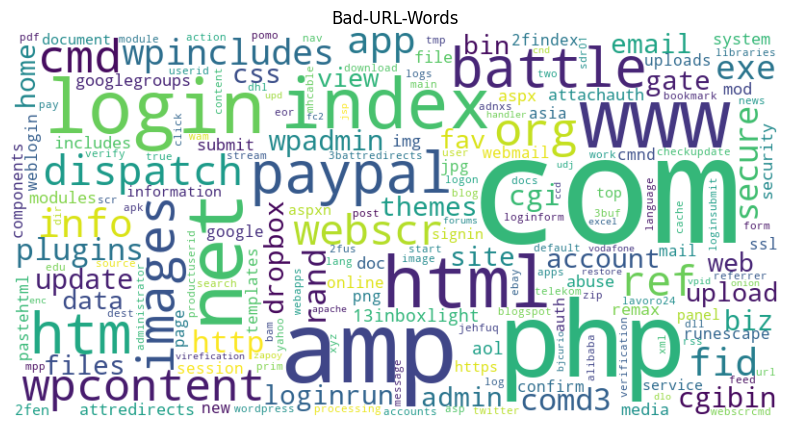

In [8]:
# THINGS: WORD CLOUD OF BAD_URL_WORDS AND GOOD_URL_WORDS. FIND INTERSECTION AND ANY CORRELATION
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from wordcloud import WordCloud

# Read the content of the file and store it in a list
with open('extracted_information/bad_url/bad_url_words.txt', 'r') as file:
  lines = file.readlines()

# Extract words and frequencies from each line in the list
word_list = [(line.split(',')[0].strip("('"), int(line.split(',')[1].strip(")\n"))) for line in lines]

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_list))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Bad-URL-Words')
plt.show()


### Word Cloud for Good URL Words

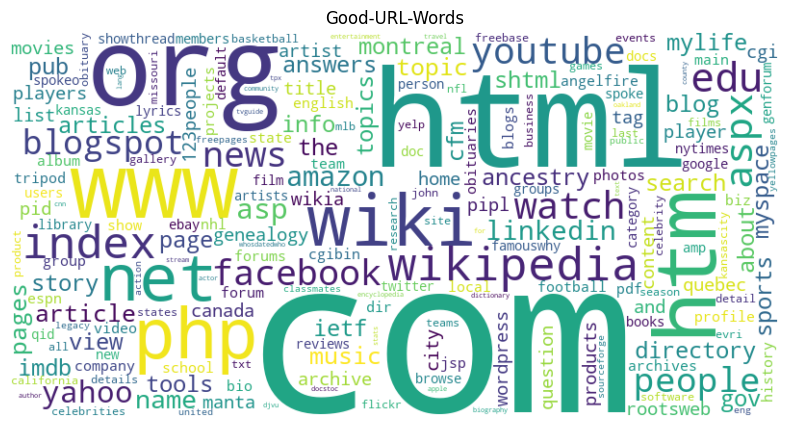

In [7]:
# Read the content of the file and store it in a list
with open('extracted_information/good_url/good_url_words.txt', 'r') as file:
  lines = file.readlines()

# Extract words and frequencies from each line in the list
word_list = [(line.split(',')[0].strip("('"), int(line.split(',')[1].strip(")\n"))) for line in lines]

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_list))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Good-URL-Words')
plt.show()


### Reading Words from bad_url_words AND good_url_words

In [30]:
def read_words_with_frequency_from_file(file_name):
  with open(file_name, 'r') as file:
    lines = file.readlines()

    # Extract words from each line in the list
    word_list = [(line.split(',')[0].strip("('"), int(line.split(',')[1].strip(")\n"))) for line in lines]

    return word_list

In [31]:
good_url_words_frequency_list = read_words_with_frequency_from_file('extracted_information/good_url/good_url_words.txt')
bad_url_words_frequency_list = read_words_with_frequency_from_file('extracted_information/bad_url/bad_url_words.txt')

In [32]:
print(bad_url_words_frequency_list)

[('com', 95306), ('php', 36657), ('amp', 33180), ('www', 22428), ('net', 18880), ('login', 17598), ('html', 16160), ('index', 15917), ('paypal', 9806), ('htm', 9680), ('battle', 8943), ('images', 7511), ('org', 6569), ('cmd', 6391), ('wpcontent', 6116), ('ref', 5224), ('webscr', 5199), ('dispatch', 5002), ('info', 4532), ('app', 4405), ('fid', 4352), ('wpincludes', 3713), ('exe', 3279), ('secure', 3096), ('rand', 2945), ('comd3', 2843), ('plugins', 2834), ('http', 2691), ('cgi', 2548), ('cgibin', 2416), ('update', 2410), ('biz', 2370), ('wpadmin', 2357), ('account', 2218), ('loginrun', 2209), ('themes', 2134), ('email', 2122), ('site', 2101), ('admin', 2035), ('gate', 1987), ('home', 1964), ('css', 1958), ('files', 1925), ('dropbox', 1925), ('web', 1835), ('view', 1798), ('bin', 1770), ('fav', 1765), ('data', 1762), ('upload', 1723), ('13inboxlight', 1640), ('aol', 1637), ('googlegroups', 1534), ('attachauth', 1527), ('attredirects', 1527), ('img', 1453), ('mod', 1442), ('aspx', 1366),

In [24]:
def read_words_from_file(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()

    # Extract words from each line in the list
    word_list = [line.split(',')[0].strip("('") for line in lines]

    return word_list

good_url_words_list = read_words_from_file('extracted_information/good_url/good_url_words.txt')
bad_url_words_list = read_words_from_file('extracted_information/bad_url/bad_url_words.txt')

#### Venn Diagram for Words

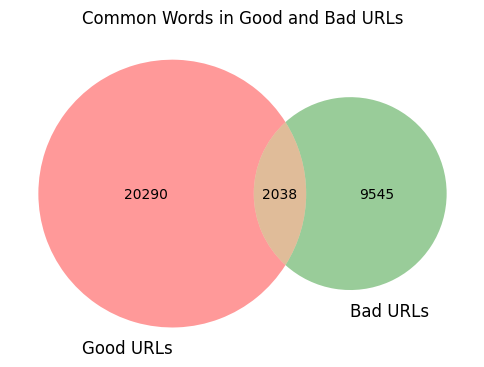

In [41]:
# Convert lists to sets
good_url_words_set = set(good_url_words_list)
bad_url_words_set = set(bad_url_words_list)

# Calculate the count for the Venn diagram
num_common_words = len(good_url_words_set.intersection(bad_url_words_set))
num_good_words = len(good_url_words_set) - num_common_words
num_bad_words = len(bad_url_words_set) - num_common_words

# Create the Venn diagram
plt.figure(figsize=(6, 6))
venn2(subsets=(num_good_words, num_bad_words, num_common_words), set_labels=('Good URLs', 'Bad URLs'))

# Add a title to the plot
plt.title('Common Words in Good and Bad URLs')

# Show the plot
plt.show()


#### Words Exclusively Only in bad_url_words and not in good_url_words

In [27]:
# Convert lists to sets
good_url_words_set = set(good_url_words_list)
bad_url_words_set = set(bad_url_words_list)

# Find the words that are in bad_url_words_list but not in good_url_words_list
words_only_in_bad_urls = bad_url_words_set - good_url_words_set

# Convert the set to a list if needed
words_only_in_bad_urls_list = list(words_only_in_bad_urls)

# Print or use the words_only_in_bad_urls_list as needed
print(words_only_in_bad_urls_list)

['worofrrt', 'hosting1fr', 'sarkanykard', 'r0r', 'bettlle', 'dinogas', 'desdr', 'fotos', 'gps', 'braindouble', 'webmaillogin', 'aficion', 'vqmod', 'tmpl', 'teatroacorte', 'zzz', 'serviciosbys', 'qijftdcnky', 'rpt', 'petitpoulet', 'confirmpaypal', 'jcnnhs', '20usaa', 'hopto', 'kongo', 'dabihfluky', 'stain', 'surestni', 'quotationfile', 'hgf65g', 'tor2web', 'wwwfull', 'kkeolnaus', 'chmail', 'jayshreeindia', 'prudy', '223ivzu', 'csoz', 'mbox', 'gdoc', 'paypal1', 'qosmvyuuwoklly', 'dongphuccaocap', 'lifestylzgh', 'brzu', 'peypal', 'mailerdaemon', 'atadrpbxx', 'webscrpatch', 'thephoneguy', 'indes', 'dav', 'greenled', 'aaiuoj', 'fixpay', 'guardiao', 'loads', 'suspendedpage', 'promosbr', 'eltbqgwtjmqvf', 'appmanager', 'hd83rd', 'woa', 'mesomedia', 'lobbyaudit', 'mikey179', 'ufdz', '7raka', 'wallst', 'callientefever', 'frilagos', 'origurl', 'wwww', 'verfication', 'mpmedia', 'steelpoolspty', 'vfsstream', 'japereznow', 'hajunina', 'updatemember', 'tozosei', 'wpthemes', 'putty', 'ppang', 'wbscrcm

#### Word Cloud for words only in bad_url_words and not in good_url_words

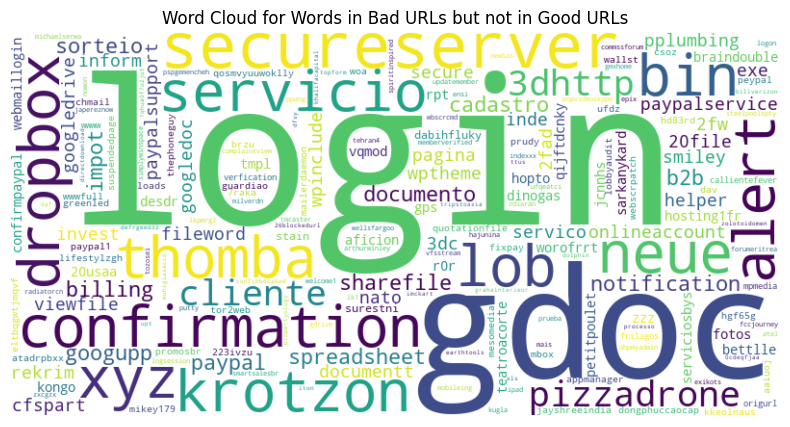

In [28]:
# Join the words into a single string for word cloud generation
words_to_display = ' '.join(words_only_in_bad_urls)

# Create the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_to_display)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Words in Bad URLs but not in Good URLs')
plt.show()

In [33]:
# Create a dictionary from 'bad_url_words_frequency_list' to easily find frequency by word
bad_url_frequency_dict = dict(bad_url_words_frequency_list)

# Create a list with words and their frequency from 'words_only_in_bad_urls_list'
words_only_in_bad_urls_with_frequency = [(word, bad_url_frequency_dict.get(word, 0)) for word in words_only_in_bad_urls_list]

# Sort the list in descending order based on the frequency value
sorted_words_only_in_bad_urls_with_frequency = sorted(words_only_in_bad_urls_with_frequency, key=lambda x: x[1], reverse=True)

[('worofrrt', 5), ('hosting1fr', 33), ('sarkanykard', 21), ('r0r', 6), ('bettlle', 6), ('dinogas', 12), ('desdr', 48), ('fotos', 23), ('gps', 37), ('braindouble', 8), ('webmaillogin', 7), ('aficion', 8), ('vqmod', 14), ('tmpl', 217), ('teatroacorte', 7), ('zzz', 9), ('serviciosbys', 6), ('qijftdcnky', 6), ('rpt', 8), ('petitpoulet', 7), ('confirmpaypal', 55), ('jcnnhs', 21), ('20usaa', 14), ('hopto', 38), ('kongo', 5), ('dabihfluky', 6), ('stain', 10), ('surestni', 5), ('quotationfile', 43), ('hgf65g', 162), ('tor2web', 238), ('wwwfull', 27), ('kkeolnaus', 7), ('chmail', 6), ('jayshreeindia', 5), ('prudy', 12), ('223ivzu', 6), ('csoz', 7), ('mbox', 5), ('gdoc', 180), ('paypal1', 36), ('qosmvyuuwoklly', 8), ('dongphuccaocap', 5), ('lifestylzgh', 8), ('brzu', 6), ('peypal', 20), ('mailerdaemon', 17), ('atadrpbxx', 6), ('webscrpatch', 9), ('thephoneguy', 8), ('indes', 8), ('dav', 6), ('greenled', 9), ('aaiuoj', 5), ('fixpay', 21), ('guardiao', 7), ('loads', 19), ('suspendedpage', 55), ('p

In [35]:
with open('extracted_information/bad_url/words_only_in_bad_urls.txt', 'w') as file:
  for item in sorted_words_only_in_bad_urls_with_frequency:
    file.write(str(item) + '\n')

### Reading Top Level Domains from bad_url_top_level_domains and good_url_top_level_domains

In [36]:
# Function to read words from a file and return them as a list

def read_tld_from_file(file_name):
  with open(file_name, 'r') as file:
      words = [word.strip() for word in file.readlines()]
  return words

# Load words from 'good_url_top_level_domains.txt' and 'bad_url_top_level_domains.txt' into lists
bad_url_tlds = read_tld_from_file('extracted_information/bad_url/bad_url_top_level_domains.txt')
good_url_tlds = read_tld_from_file('extracted_information/good_url/good_url_top_level_domains.txt')

#### Venn Diagram for Top Level Domains

386
385


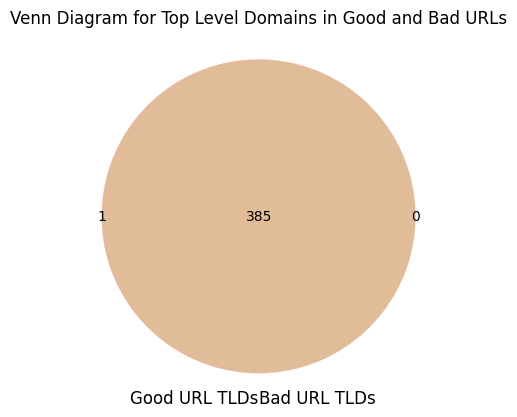

In [40]:
# Convert lists to sets
good_url_tlds_set = set(good_url_tlds)
bad_url_tlds_set = set(bad_url_tlds)

# Calculate the count for the Venn diagram
num_common_tlds = len(good_url_tlds_set.intersection(bad_url_tlds_set))
num_good_tlds = len(good_url_tlds_set) - num_common_tlds
num_bad_tlds = len(bad_url_tlds_set) - num_common_tlds

venn2(subsets=(num_good_tlds, num_bad_tlds, num_common_tlds),
      set_labels=('Good URL TLDs', 'Bad URL TLDs'))

print(len(good_url_tlds_set))
print(len(bad_url_tlds_set))

# Add a title to the plot
plt.title('Venn Diagram for Top Level Domains in Good and Bad URLs')

# Show the plot
plt.show()

#### Plots for Comparison of Frequency of Common Words Having Percentage Frequency in Bad Words >= 70

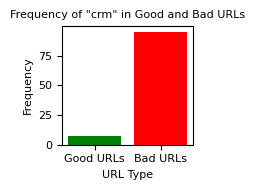

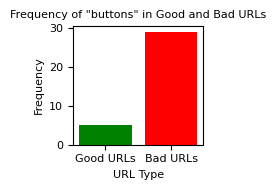

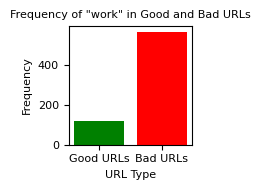

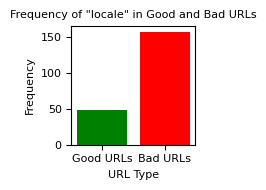

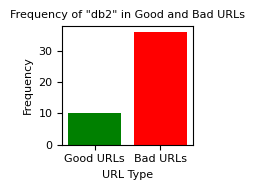

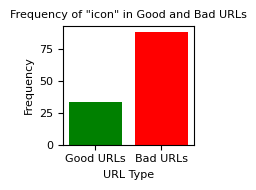

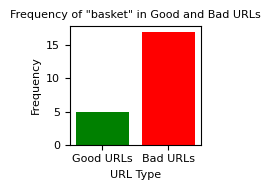

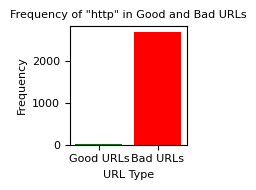

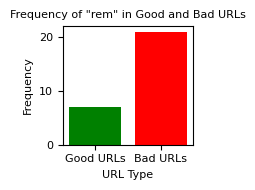

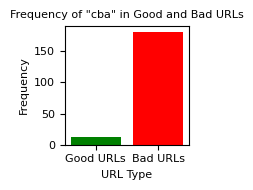

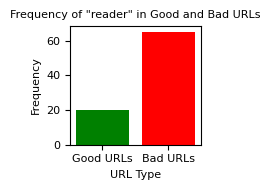

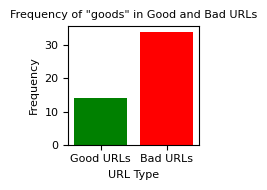

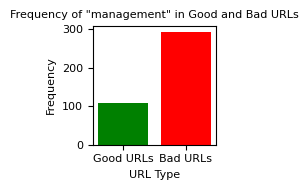

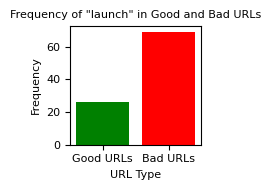

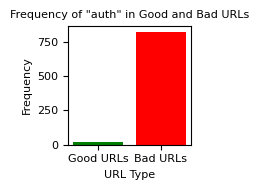

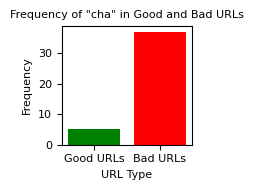

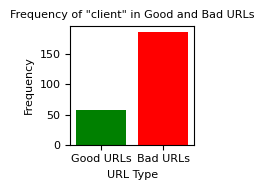

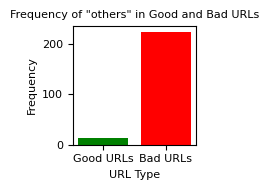

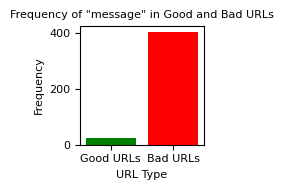

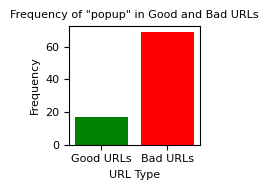

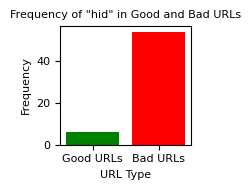

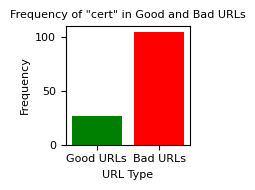

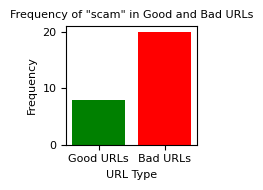

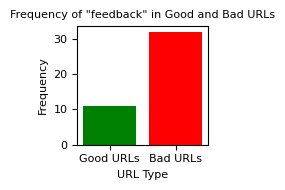

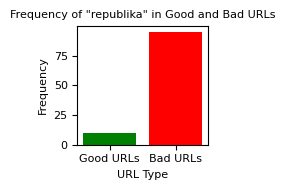

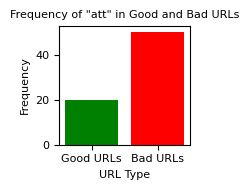

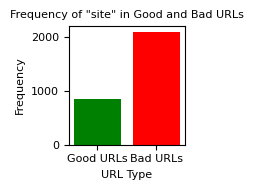

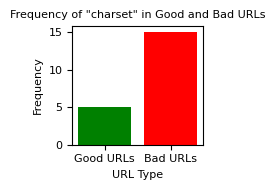

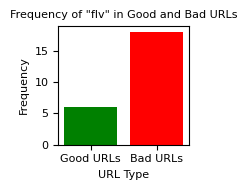

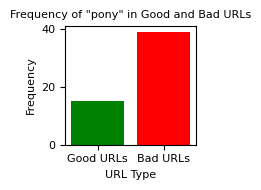

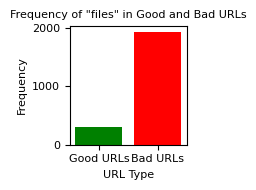

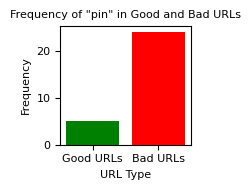

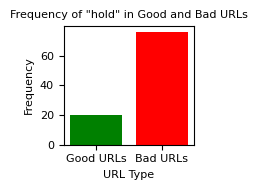

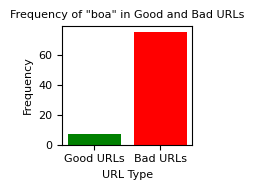

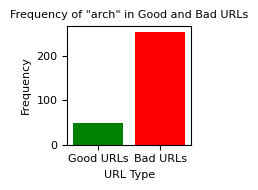

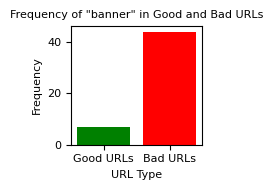

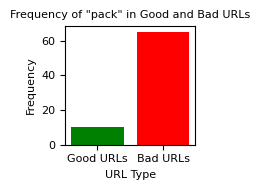

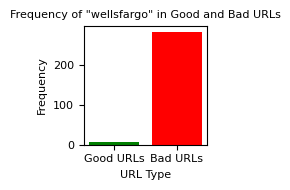

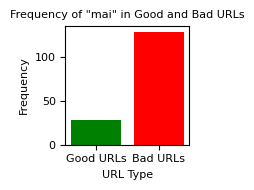

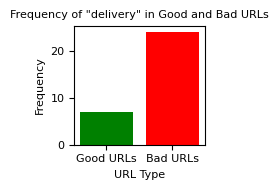

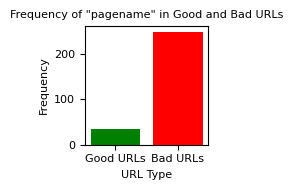

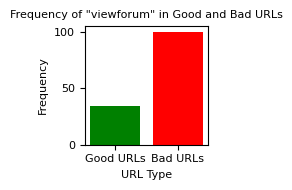

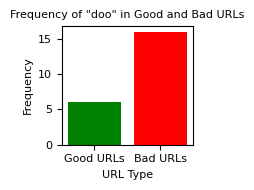

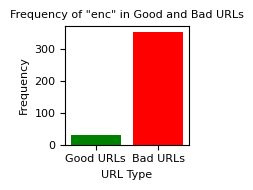

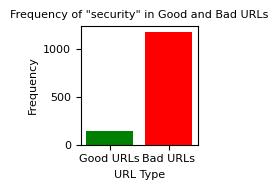

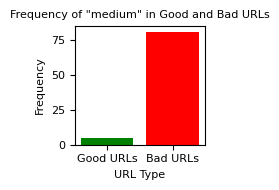

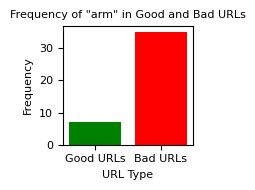

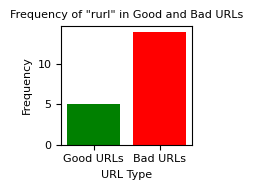

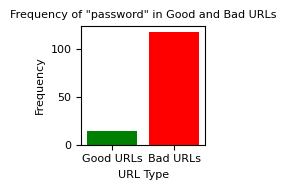

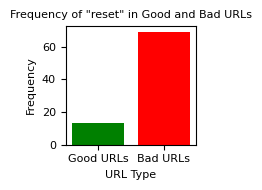

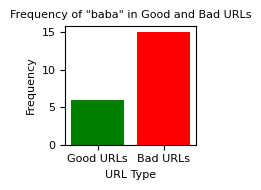

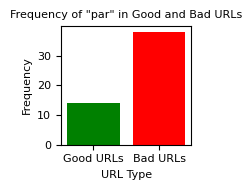

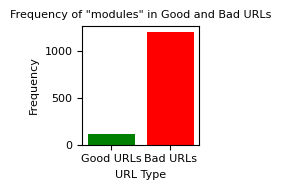

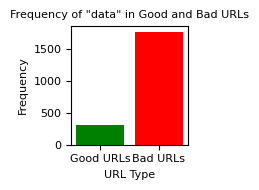

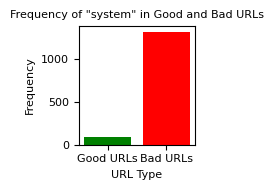

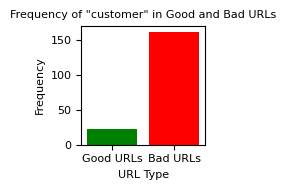

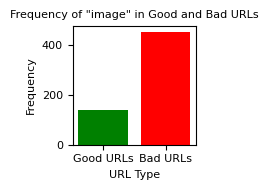

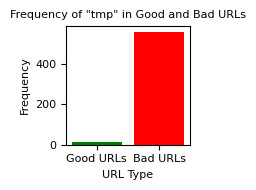

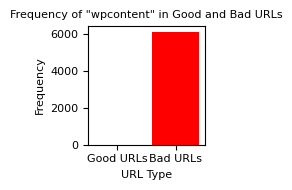

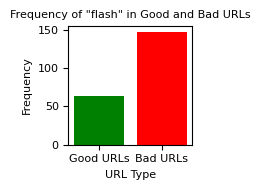

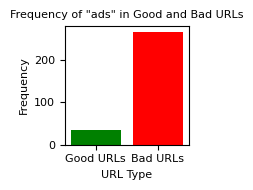

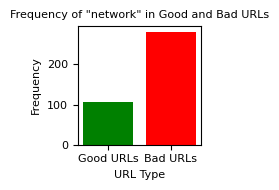

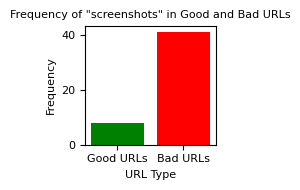

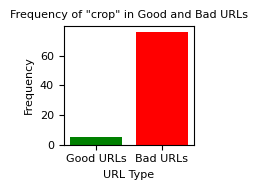

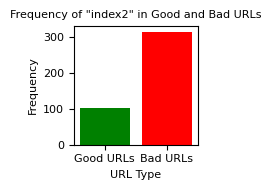

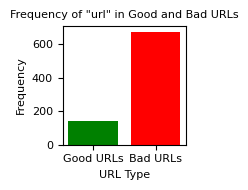

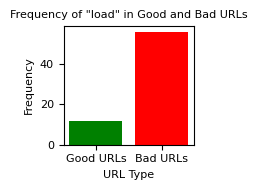

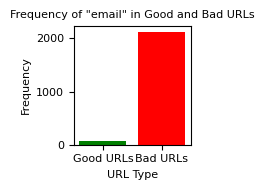

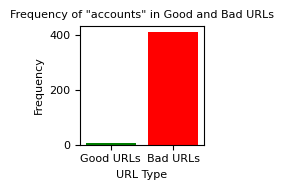

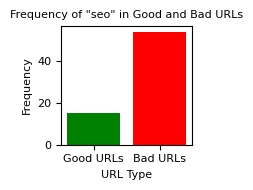

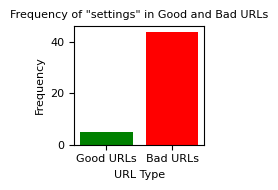

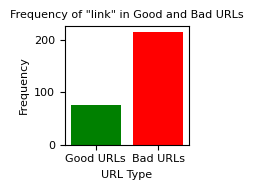

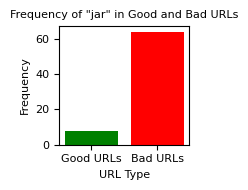

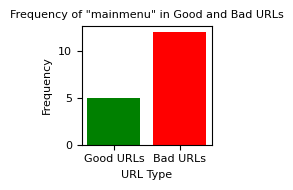

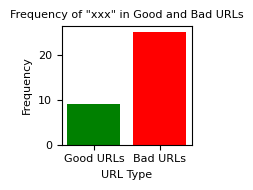

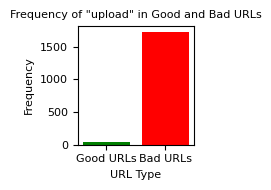

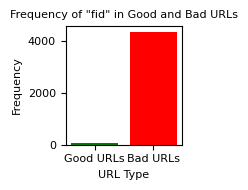

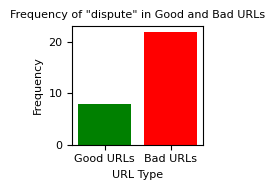

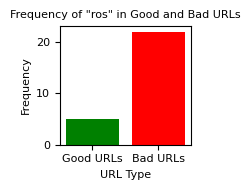

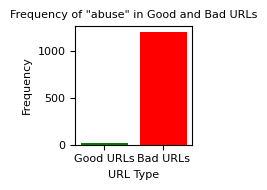

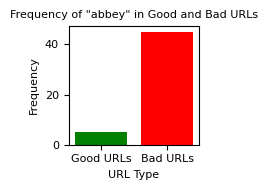

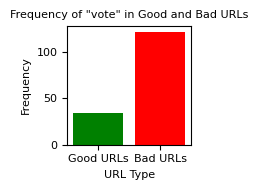

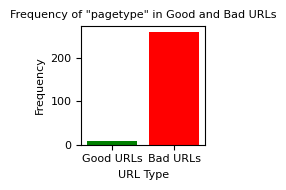

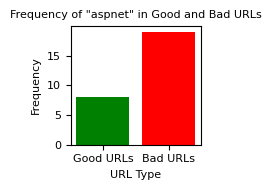

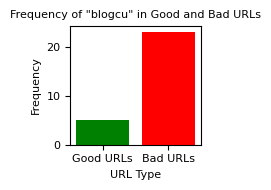

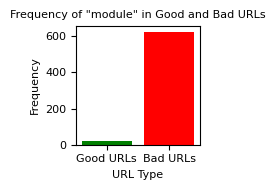

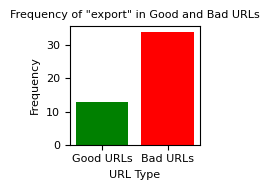

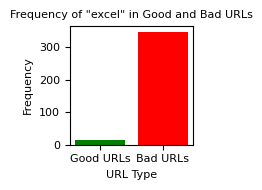

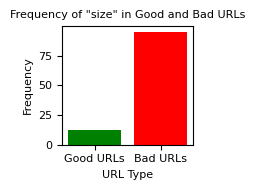

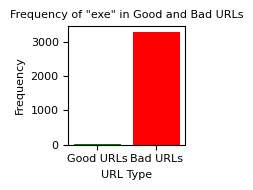

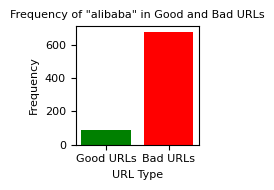

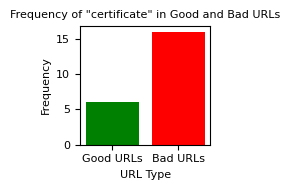

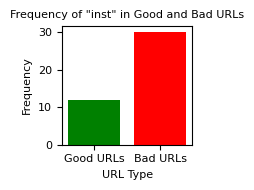

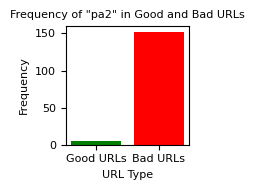

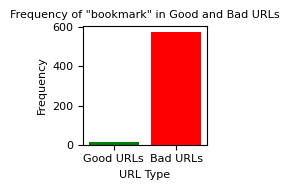

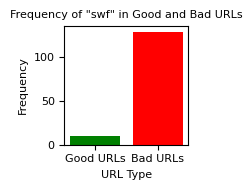

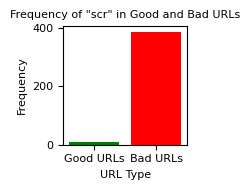

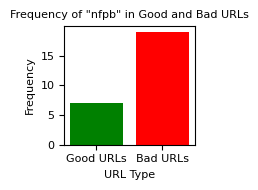

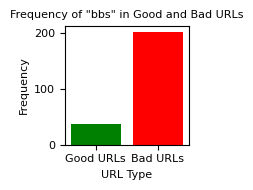

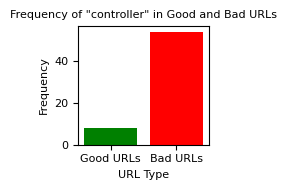

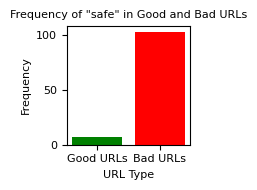

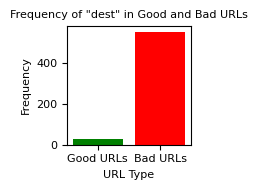

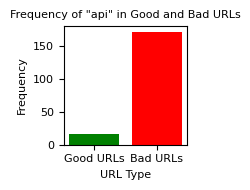

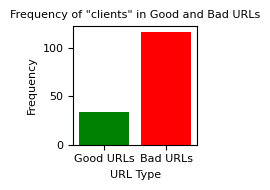

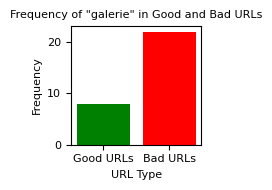

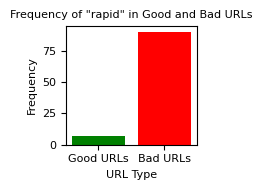

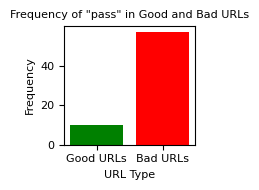

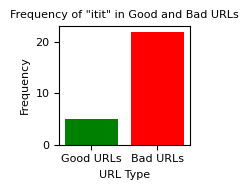

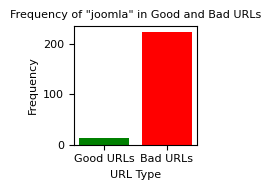

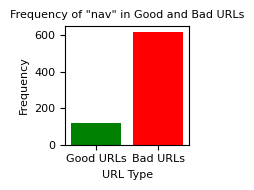

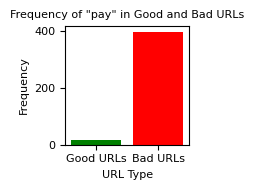

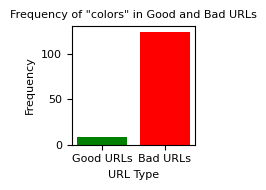

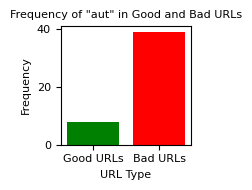

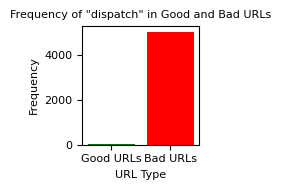

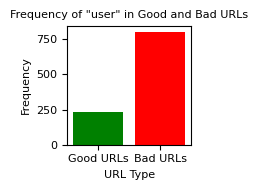

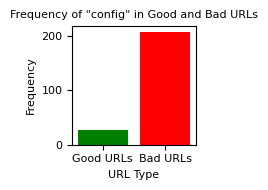

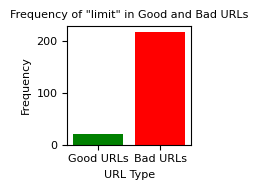

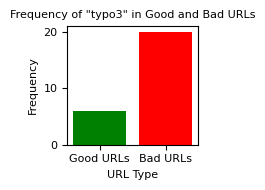

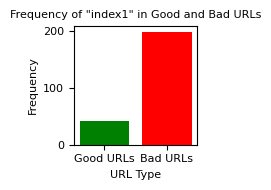

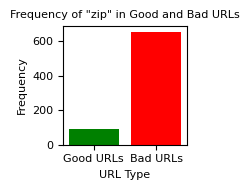

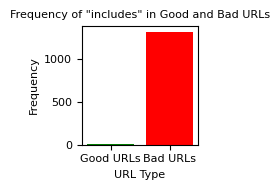

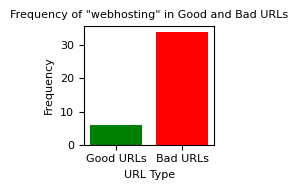

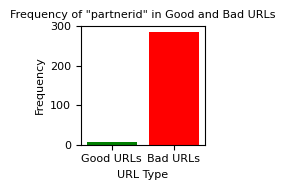

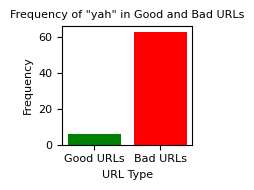

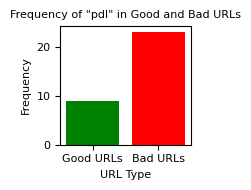

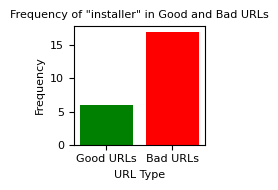

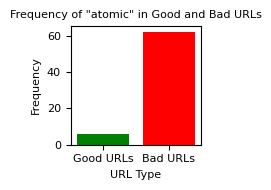

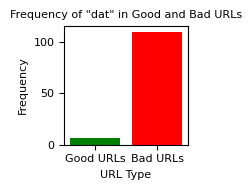

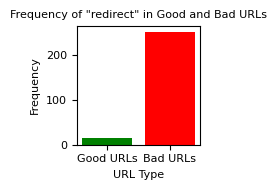

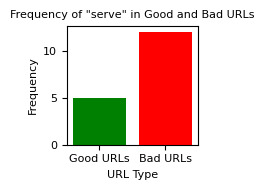

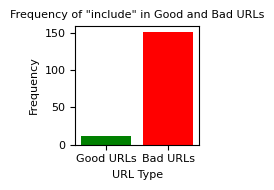

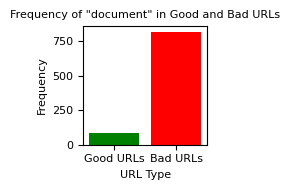

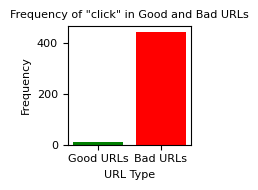

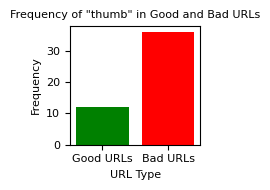

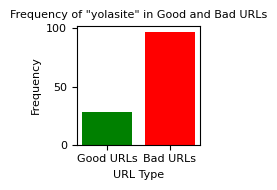

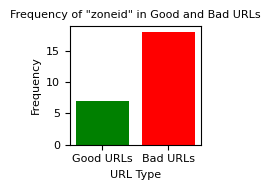

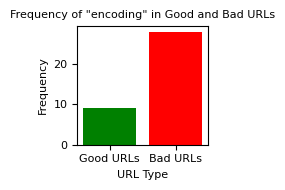

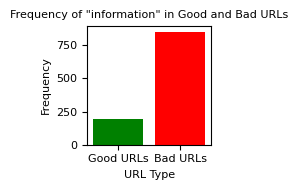

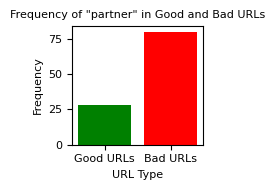

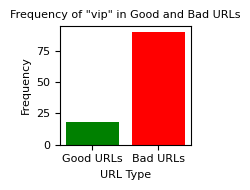

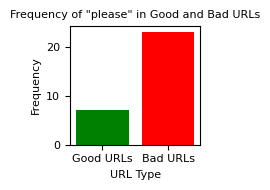

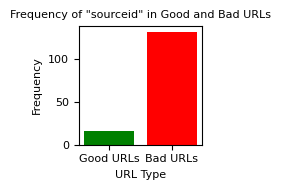

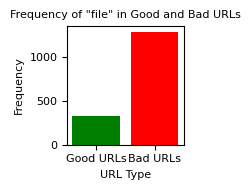

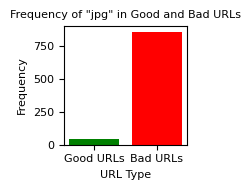

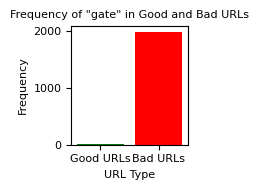

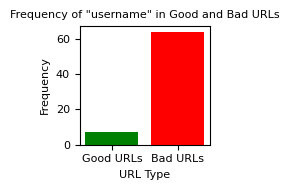

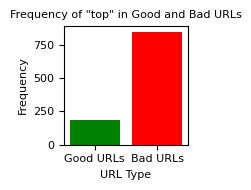

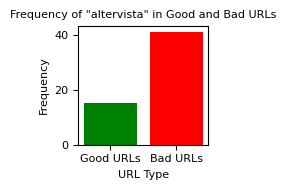

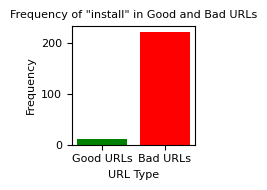

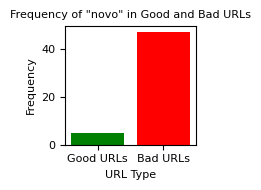

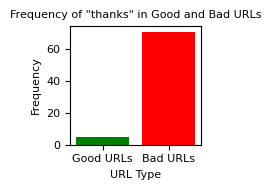

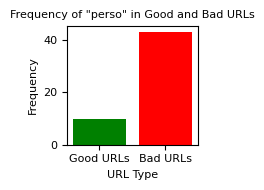

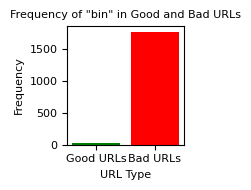

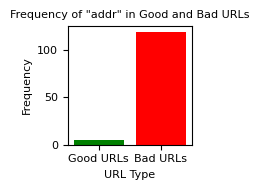

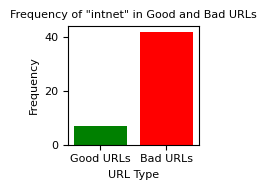

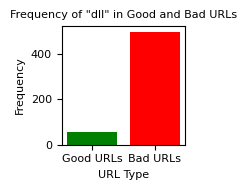

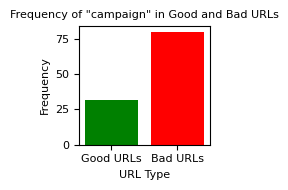

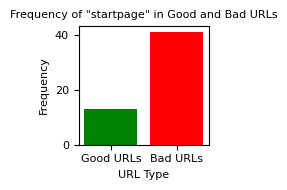

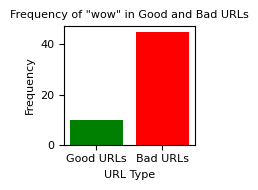

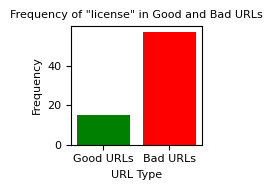

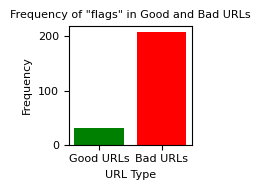

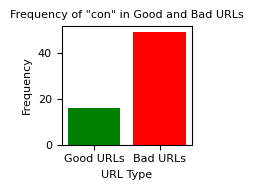

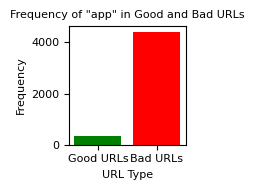

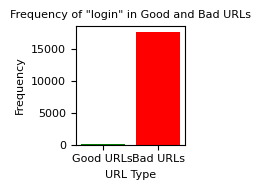

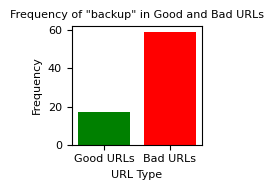

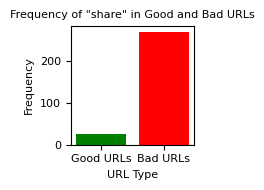

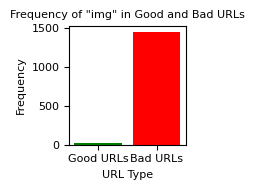

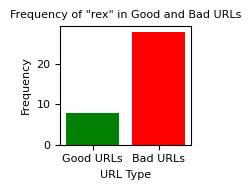

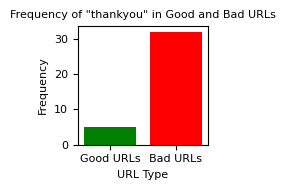

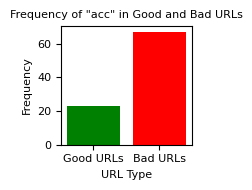

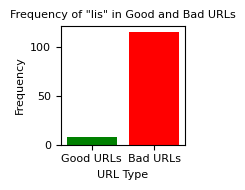

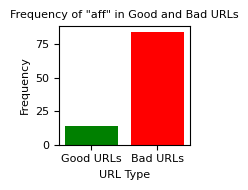

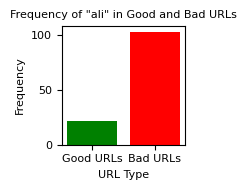

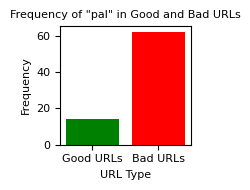

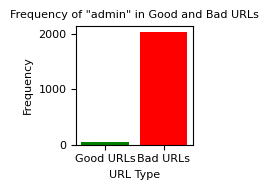

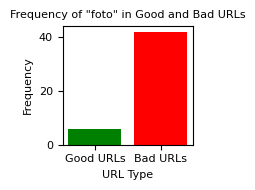

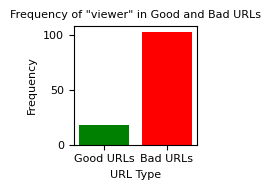

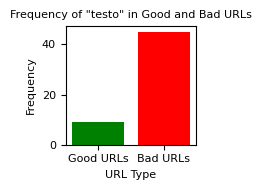

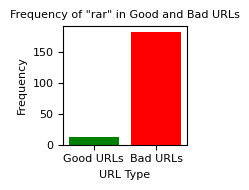

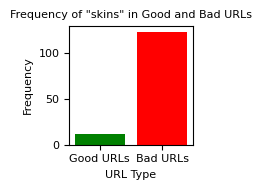

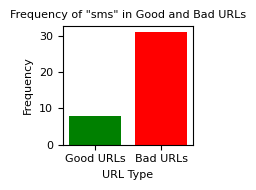

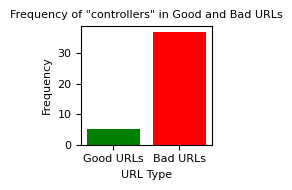

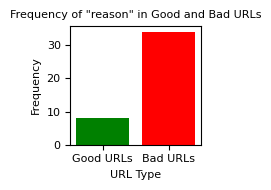

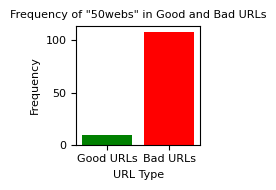

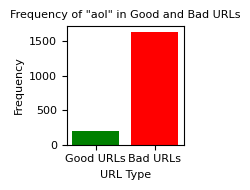

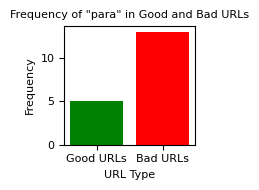

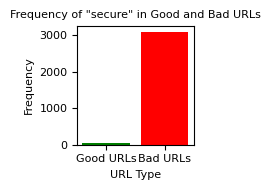

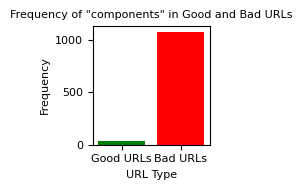

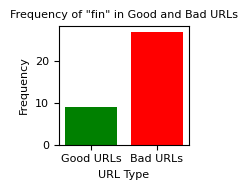

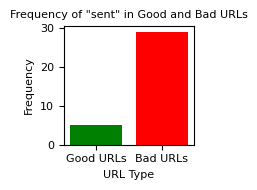

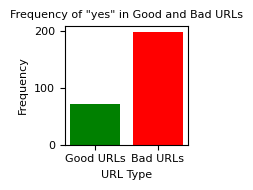

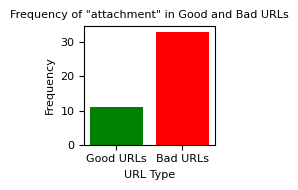

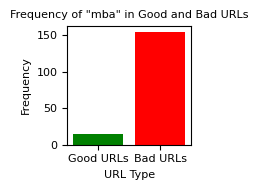

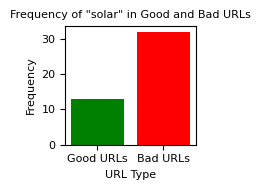

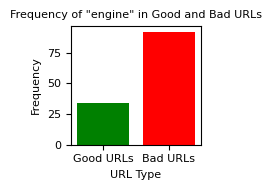

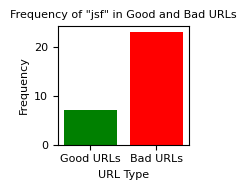

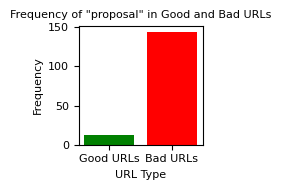

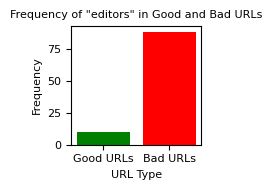

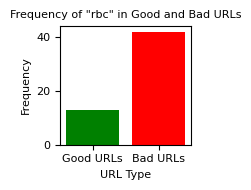

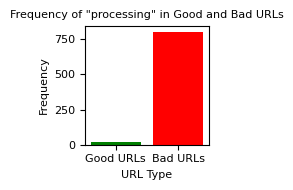

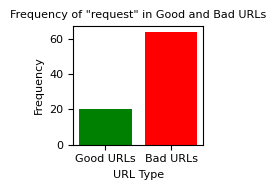

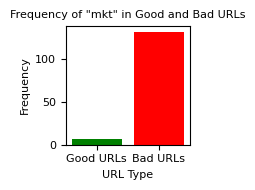

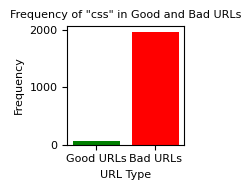

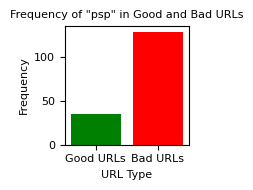

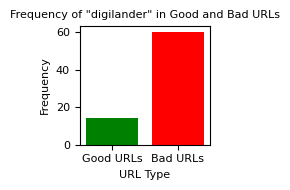

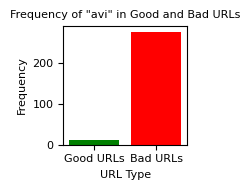

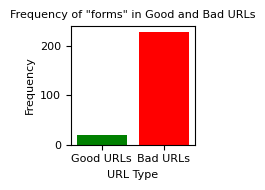

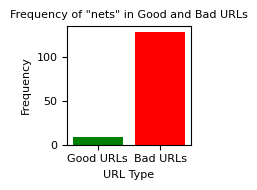

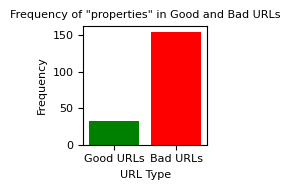

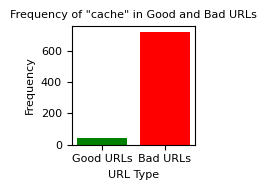

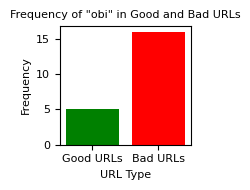

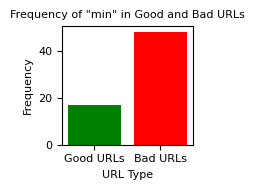

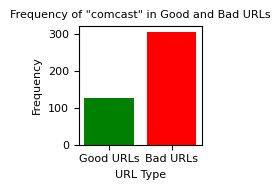

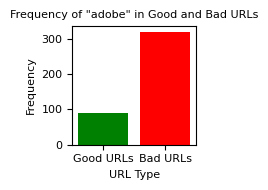

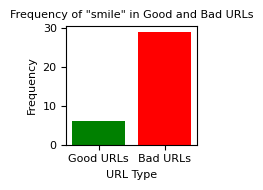

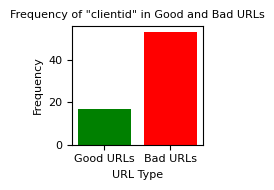

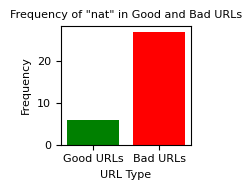

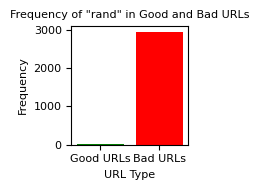

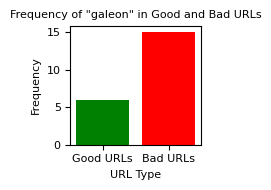

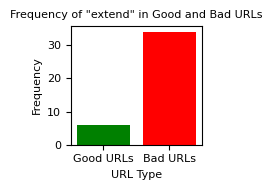

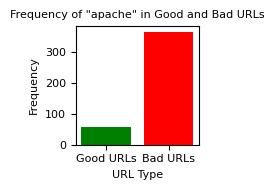

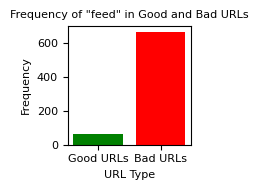

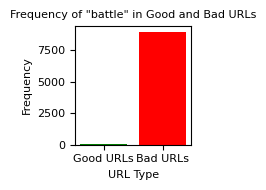

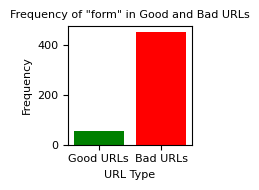

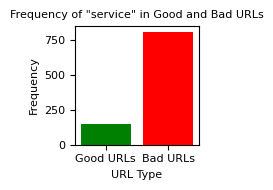

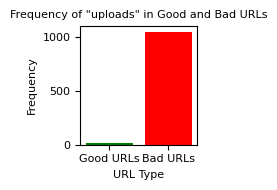

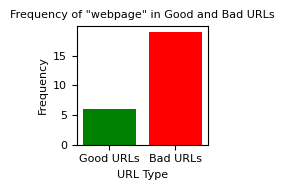

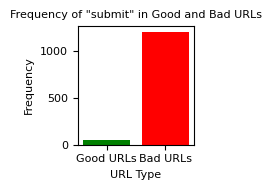

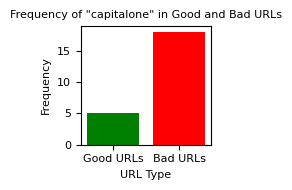

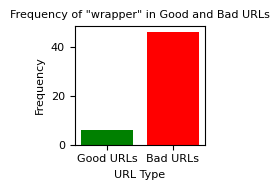

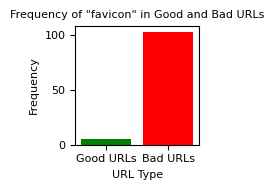

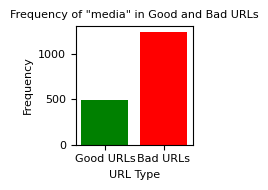

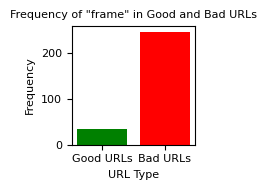

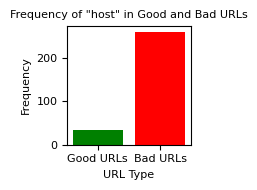

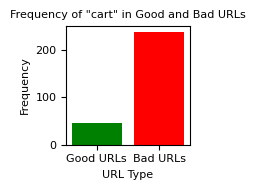

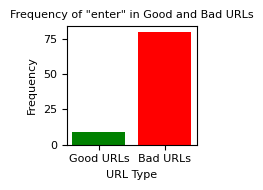

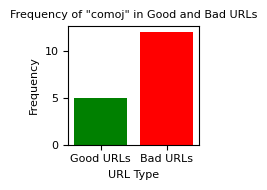

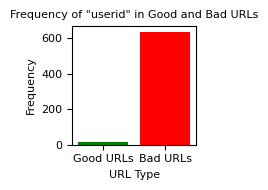

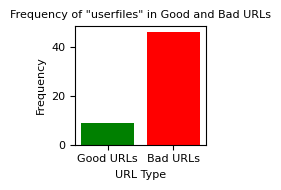

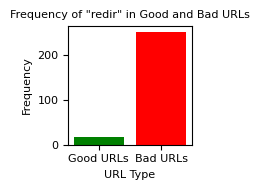

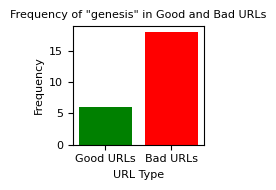

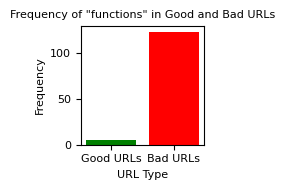

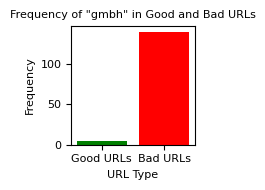

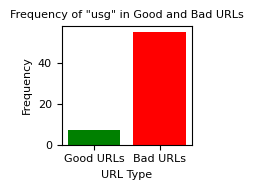

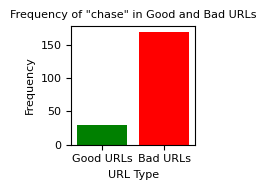

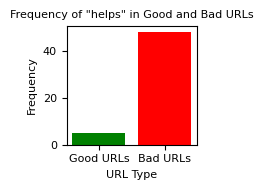

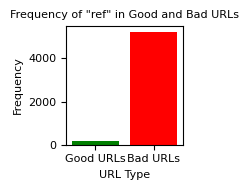

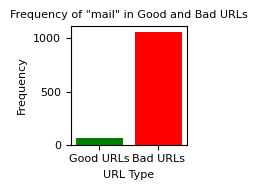

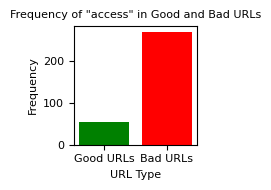

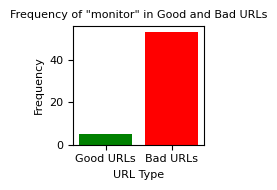

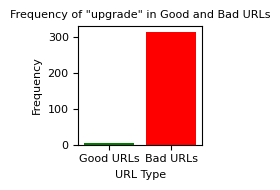

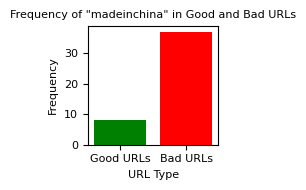

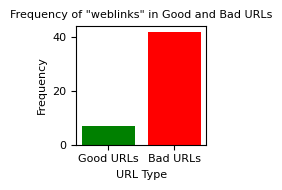

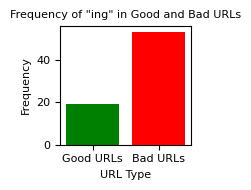

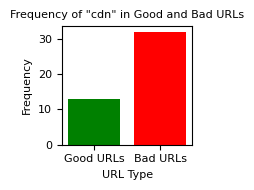

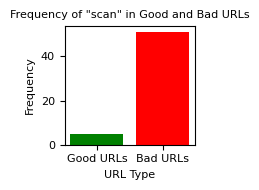

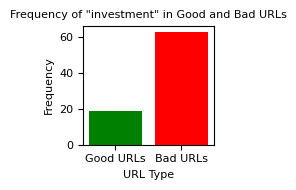

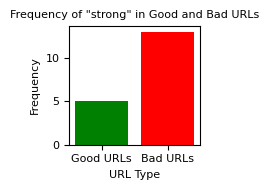

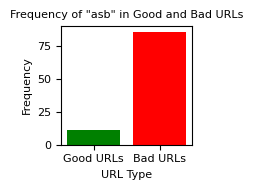

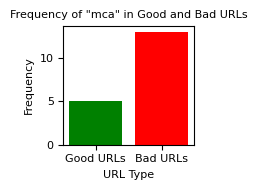

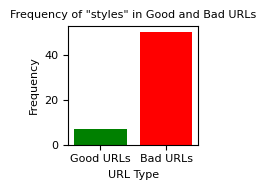

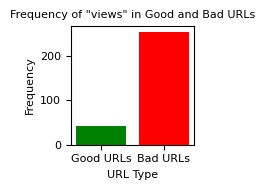

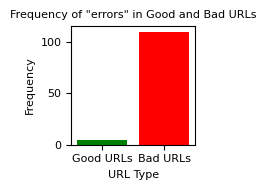

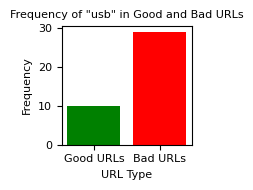

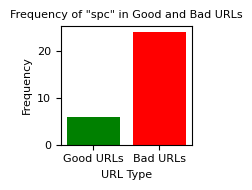

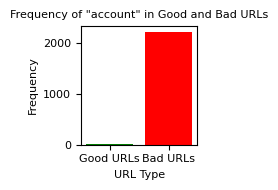

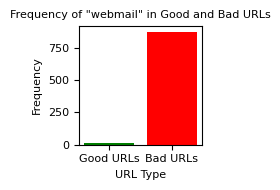

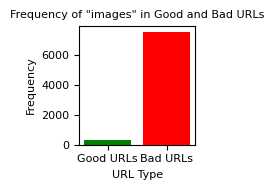

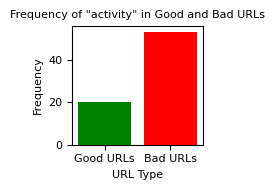

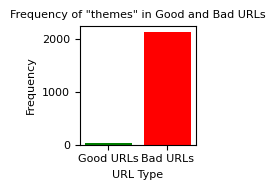

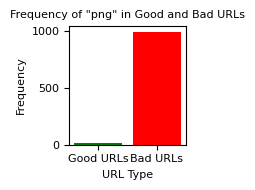

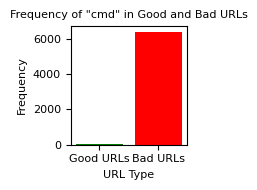

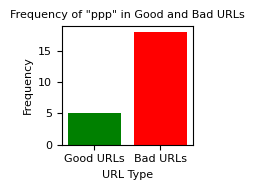

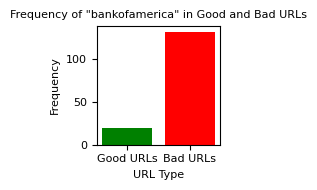

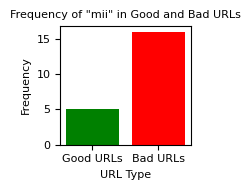

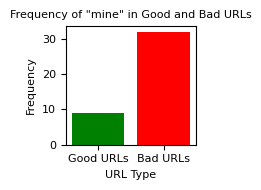

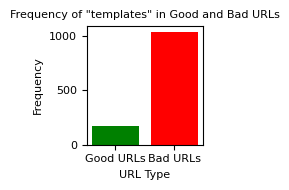

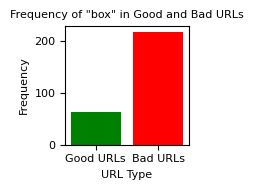

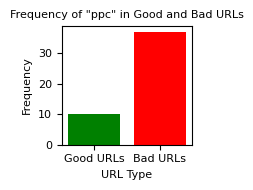

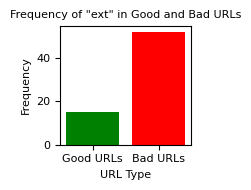

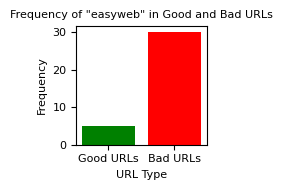

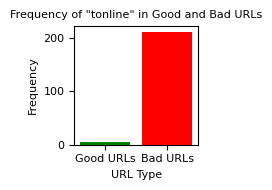

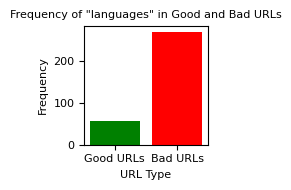

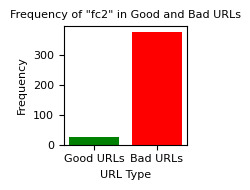

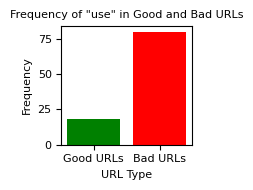

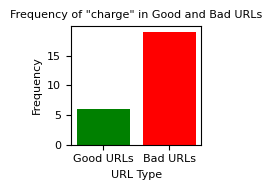

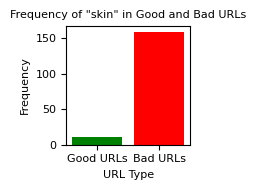

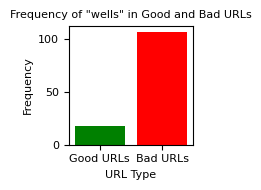

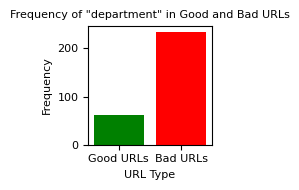

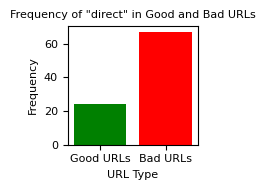

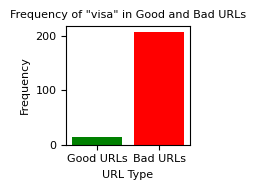

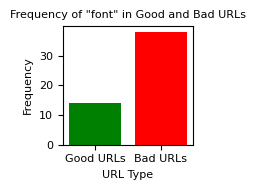

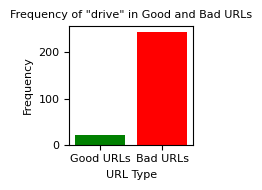

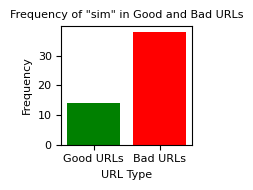

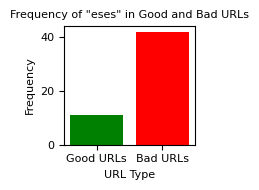

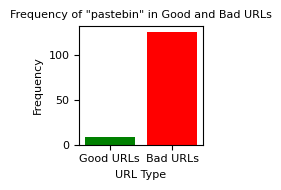

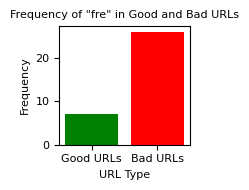

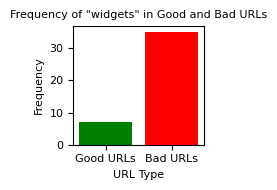

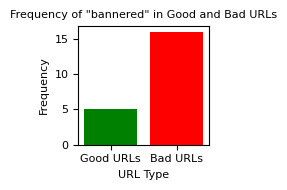

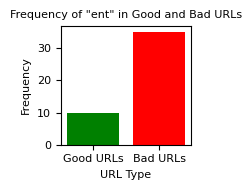

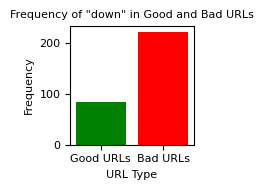

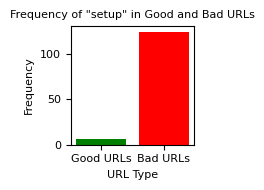

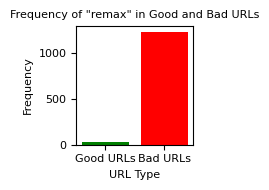

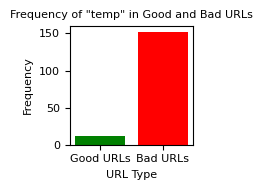

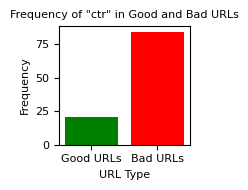

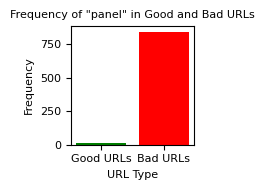

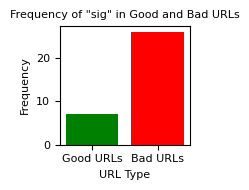

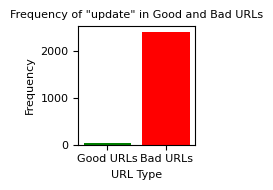

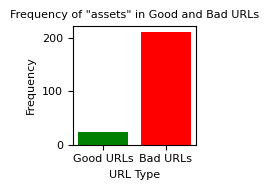

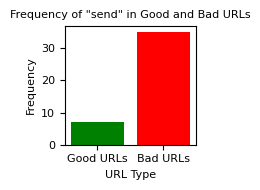

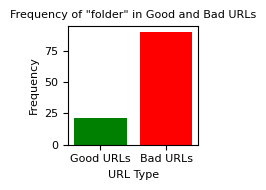

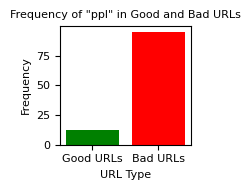

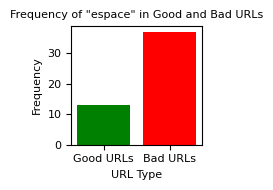

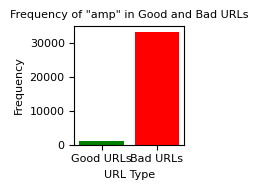

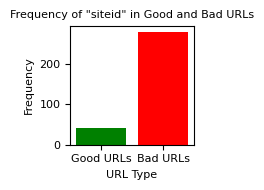

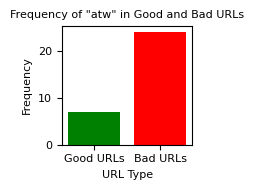

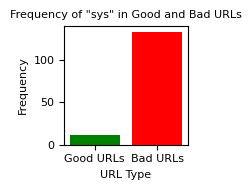

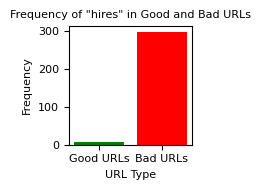

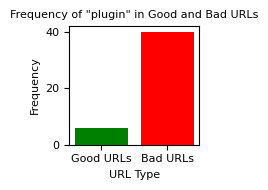

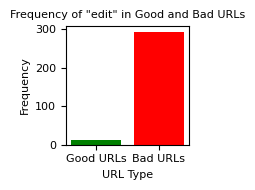

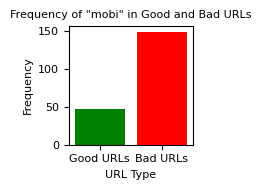

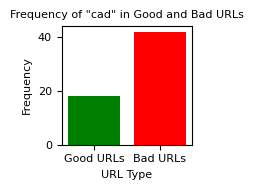

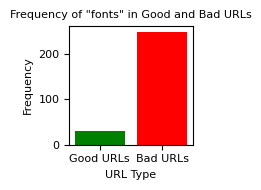

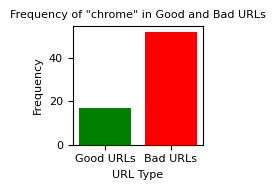

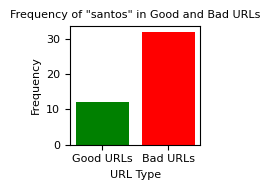

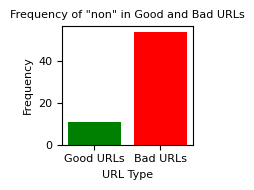

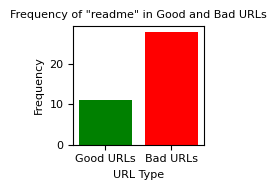

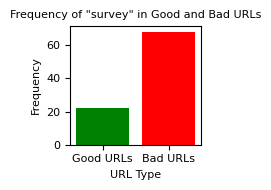

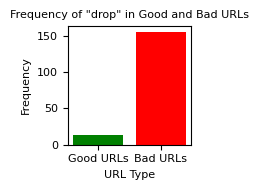

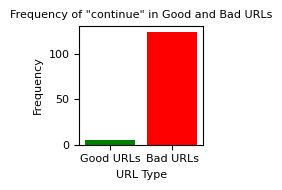

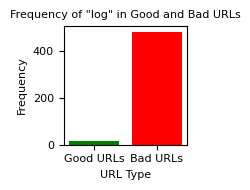

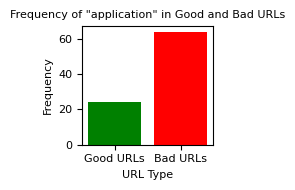

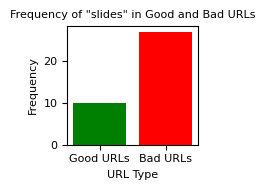

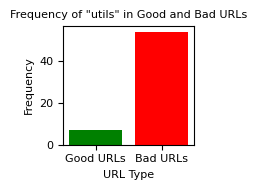

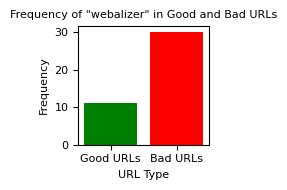

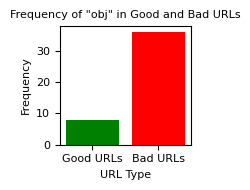

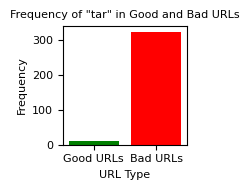

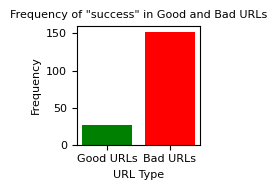

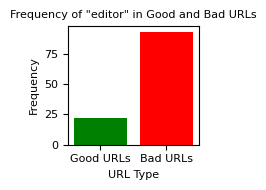

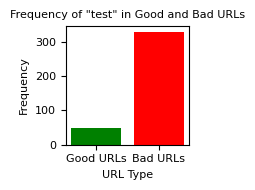

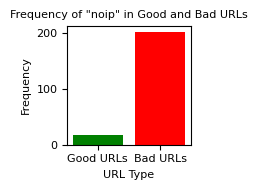

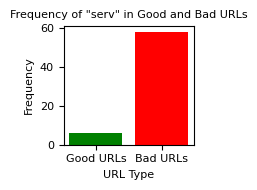

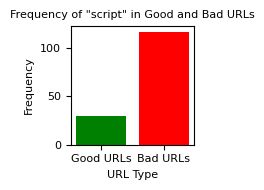

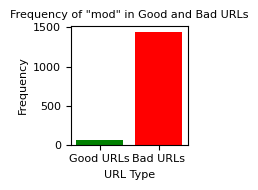

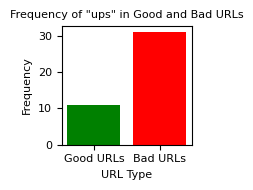

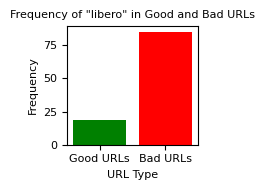

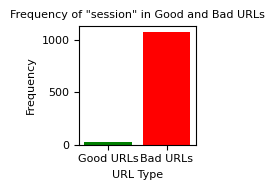

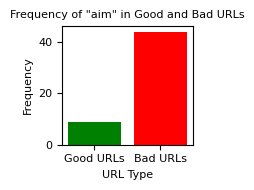

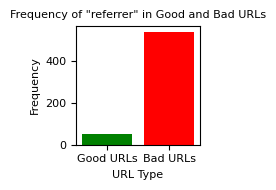

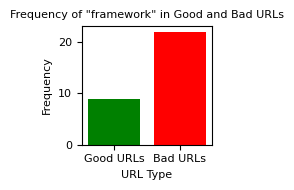

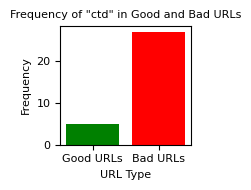

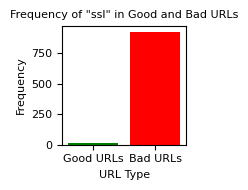

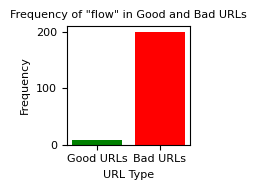

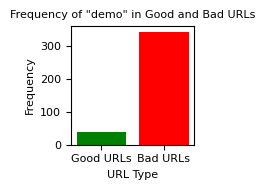

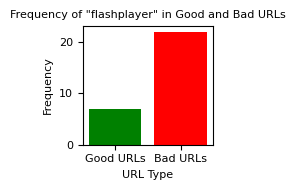

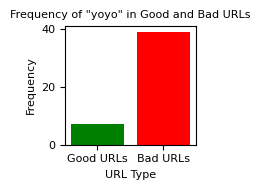

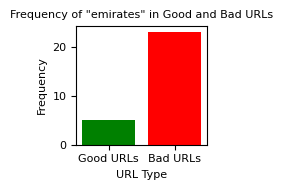

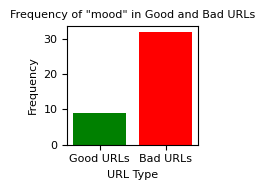

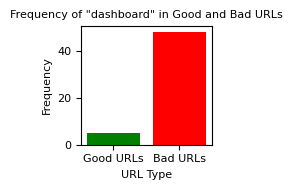

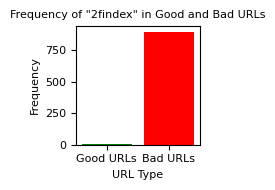

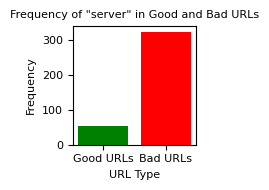

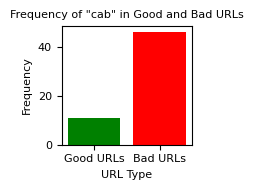

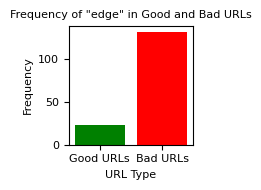

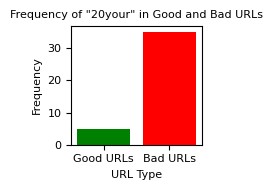

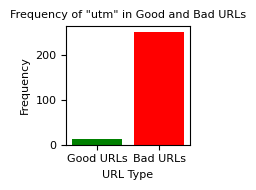

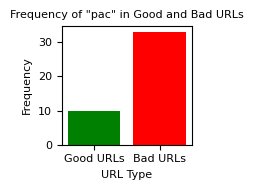

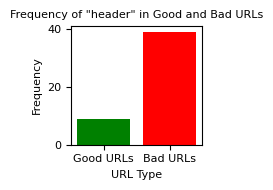

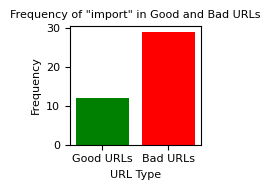

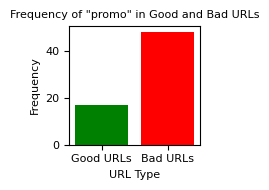

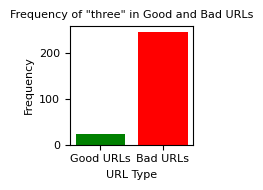

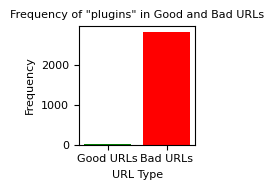

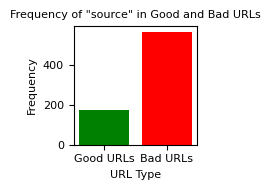

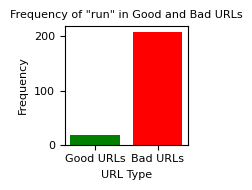

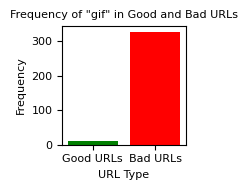

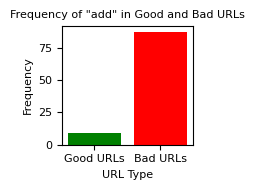

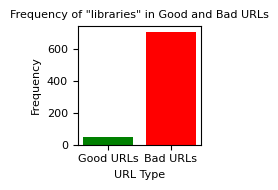

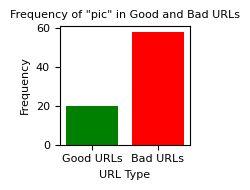

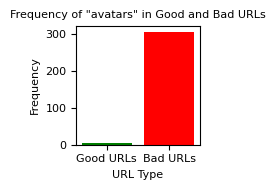

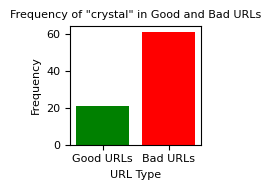

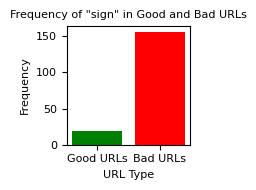

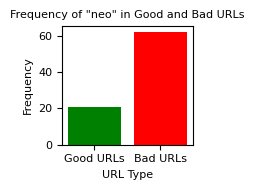

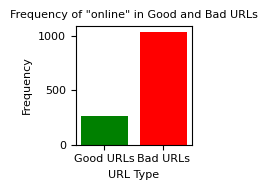

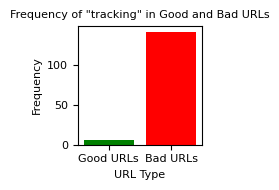

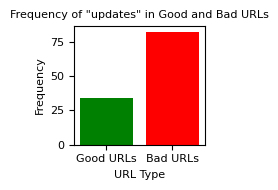

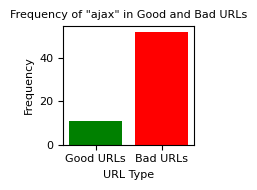

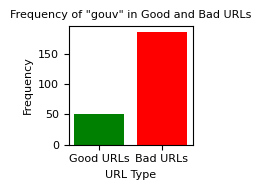

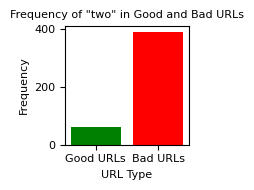

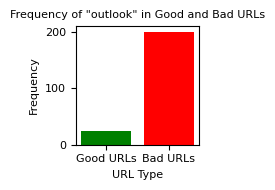

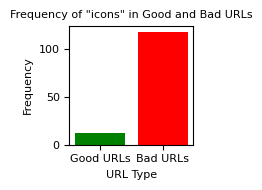

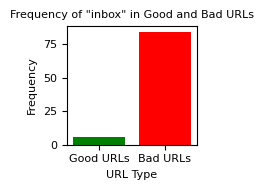

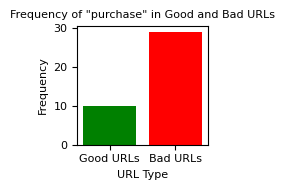

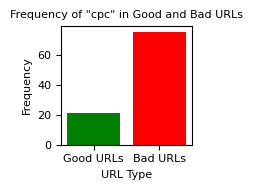

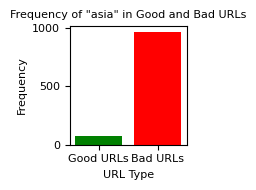

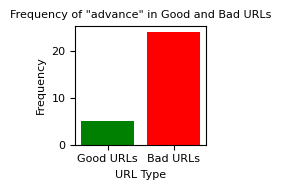

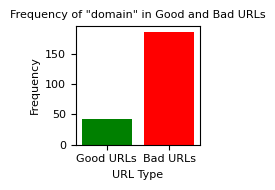

In [52]:
# Function to read words and their frequencies from a file and return them as a list of tuples
def read_words_with_frequencies_from_file(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
    words_with_frequencies = [eval(line.strip()) for line in lines]  # Using eval to convert string representation to tuples
    return words_with_frequencies

# Load words and their frequencies from 'good_url_words.txt' and 'bad_url_words.txt' into lists
good_url_words_frequencies = read_words_with_frequencies_from_file('extracted_information/good_url/good_url_words.txt')
bad_url_words_frequencies = read_words_with_frequencies_from_file('extracted_information/bad_url/bad_url_words.txt')

# Extract words from each list
good_url_words = [word for word, _ in good_url_words_frequencies]
bad_url_words = [word for word, _ in bad_url_words_frequencies]

# Convert lists to sets
good_url_words_set = set(good_url_words)
bad_url_words_set = set(bad_url_words)

# Find the words that are common in both sets
common_words = good_url_words_set.intersection(bad_url_words_set)

bad_words = []

for word in common_words:
    good_frequency = dict(good_url_words_frequencies).get(word, 0)
    bad_frequency = dict(bad_url_words_frequencies).get(word, 0)
    
    # Check if bad_frequency is greater than good_frequency and the percentage of bad_frequency is greater than 70
    if bad_frequency > good_frequency and ((bad_frequency/(good_frequency+bad_frequency))*100) >= 70:
        bad_words.append((word, bad_frequency))
        plt.figure(figsize=(2, 2))
        plt.bar(['Good URLs', 'Bad URLs'], [good_frequency, bad_frequency], color=['green', 'red'])
        plt.xlabel('URL Type', fontsize=8)
        plt.ylabel('Frequency', fontsize=8)
        plt.title(f'Frequency of "{word}" in Good and Bad URLs', fontsize=8)
        plt.xticks(fontsize=8)  
        plt.yticks(fontsize=8)
        plt.tight_layout()
        plt.show()


In [55]:
with open('extracted_information/bad_url/words_in_common_greater_than_70.txt', 'w', encoding='utf-8') as file:
  for item in bad_words:
    file.write(str(item) + '\n')


### Other